### Imports

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple, Callable, Dict, List, Any

%matplotlib inline


### Read and Preprocess Data

In [15]:
raw_dataframe = pd.read_excel("energy+efficiency/ENB2012_data.xlsx")

print(raw_dataframe.head())
print('Mean of the raw_dataframe:')
print(raw_dataframe.mean())
print('Standard deviation of the raw_dataframe:')
print(raw_dataframe.std())

# Normalizing the data

# dataframe = raw_dataframe.copy()
dataframe = (raw_dataframe - raw_dataframe.mean()) / (raw_dataframe.max() - raw_dataframe.min())
print(dataframe.head())

# Shuffle the data
dataframe = dataframe.sample(frac=1).reset_index(drop=True)

print(dataframe.head())

X_train = dataframe.iloc[:, :-2]
Y_train = dataframe.iloc[:, -2:]

print(X_train.head())
print(Y_train.head())

     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
Mean of the raw_dataframe:
X1      0.764167
X2    671.708333
X3    318.500000
X4    176.604167
X5      5.250000
X6      3.500000
X7      0.234375
X8      2.812500
Y1     22.307195
Y2     24.587760
dtype: float64
Standard deviation of the raw_dataframe:
X1     0.105777
X2    88.086116
X3    43.626481
X4    45.165950
X5     1.751140
X6     1.118763
X7     0.133221
X8     1.550960
Y1    10.090204
Y2     9.513306
dtype: float64
         X1        X2        X3        X4   X5        X6        X7      X8  \
0  0.599537 -0.534722 -0.142857 -0.601852  0.5 -0.500000 -0.585938 -0.5625   
1  0.599537 -0.534722 -0.142857 -0.601852  0

### Data Visualization

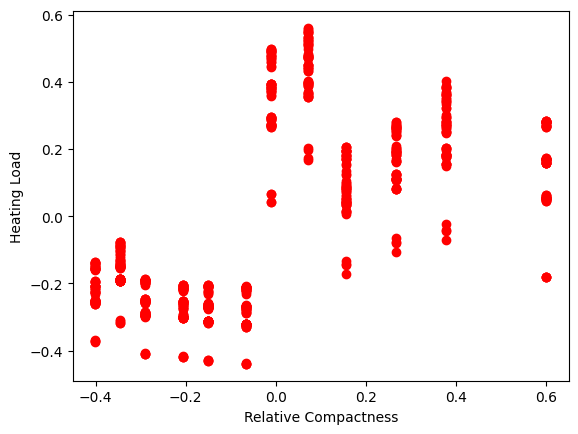

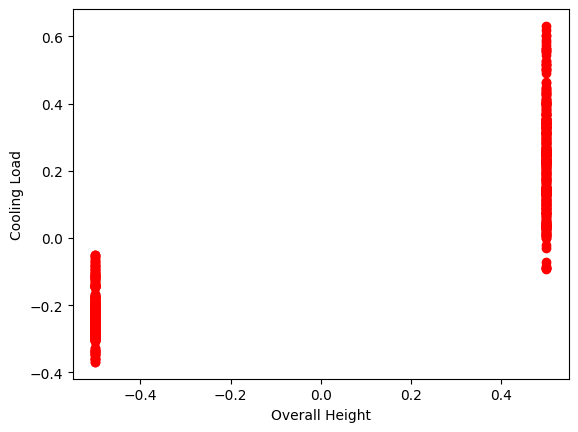

In [16]:
plt.plot(dataframe['X1'], dataframe['Y1'], 'ro')
plt.xlabel('Relative Compactness')
plt.ylabel('Heating Load')
plt.show()

plt.plot(dataframe['X5'], dataframe['Y2'], 'ro')
plt.xlabel('Overall Height')
plt.ylabel('Cooling Load')
plt.show()

### Kernels

In [17]:
def se_kernel(
    sigma: float,
    bandwidth: float,
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    """ Here we define the kernel function. We use the squared exponential kernel. The kernel function is used to calculate the covariance matrix.

    Args:
        sigma (float) : The standard deviation of the Gaussian distribution.
        bandwidth (float) : The bandwidth of the Gaussian distribution.
        x (np.ndarray) : The first point at which the kernel function is to be evaluated.
        y (np.ndarray) : The second point at which the kernel function is to be evaluated.

    Returns:
        float: The value of the kernel function at points x and y.
    """
    return np.exp(-1 * np.sum(np.square(x - y)) / (2 * bandwidth ** 2)) * sigma ** 2

# END def kernel

In [18]:

def kernel_matrix(
    kernel: Callable,
    X: np.ndarray,
    Y: np.ndarray,
) -> np.ndarray:
    """ Here we define the kernel matrix. The kernel matrix is used to calculate the covariance matrix.

    Args:
        sigma (float) : The standard deviation of the Gaussian distribution.
        bandwidth (float) : The bandwidth of the Gaussian distribution.
        X (np.ndarray) : The data matrix
        Y (np.ndarray) : The data matrix

    Returns:
        np.ndarray: The kernel matrix.
    """

    N1 = X.shape[0]
    N2 = Y.shape[0]

    K = np.zeros((N1, N2))

    for i in range(N1):
        for j in range(N2):
            K[i, j] = kernel(X[i], Y[j])
        # END for j
    # END for i

    return K

# END def kernel_matrix

In [19]:
ker_mat = kernel_matrix(lambda x, y: se_kernel(1, 1, x, y), X_train.to_numpy(), X_train.to_numpy())
print(ker_mat)

[[1.         0.36274248 0.79937745 ... 0.34315147 0.37728856 0.68707453]
 [0.36274248 1.         0.23042181 ... 0.86004113 0.85968387 0.24923112]
 [0.79937745 0.23042181 1.         ... 0.27311639 0.21911991 0.54615114]
 ...
 [0.34315147 0.86004113 0.27311639 ... 1.         0.72535973 0.18546375]
 [0.37728856 0.85968387 0.21911991 ... 0.72535973 1.         0.23120917]
 [0.68707453 0.24923112 0.54615114 ... 0.18546375 0.23120917 1.        ]]


### Gaussian Process Regression Class

In [20]:
class GaussianProcessRegression:
    """ Here we define the GaussianProcessRegression class. 
        The GaussianProcessRegression class is used to fit the Gaussian Process Regression model 
                to the data and predict the output for the test data.
    """

    def __init__(
        self,
        kernels: List[Callable],
    ) -> None:
        """ Here we initialize the GaussianProcessRegression class.

        Args:
            sigma (float) : The standard deviation of the Gaussian distribution.
            bandwidth (float) : The bandwidth of the Gaussian distribution.
            X (np.ndarray) : The training data.
            Y (np.ndarray) : The output for the training data.
        """

        self.kernels = kernels
    # END def __init__

    def fit(
        self,
        X_train: np.ndarray,
        Y_train: np.ndarray,
    ) -> None:
        """ Here we fit the Gaussian Process Regression model to the data.

        Args:
            X (np.ndarray) : The training data.
            Y (np.ndarray) : The output for the training data.

        """

        self.X_train = X_train
        self.Y_train = Y_train
        self.K = [kernel_matrix(k, X_train, X_train) for k in self.kernels]
        self.K_inv = [np.linalg.inv(k) for k in self.K]

    # END def fit

    def predict(
        self,
        X_test: np.ndarray,
    ) -> Tuple[np.ndarray, np.ndarray]:
        """ Here we predict the output for the test data.

        Args:
            X (np.ndarray) : The test data.

        Returns:
            np.ndarray: The means of the predicted output for the test data.
            np.ndarray: The variance of the predicted output for the test data.
        """

        y_pred_mean = np.zeros((X_test.shape[0],
                                Y_train.shape[1]))

        y_pred_var = np.zeros((X_test.shape[0],
                               Y_train.shape[1]))

        for i in range(Y_train.shape[1]):
            k_star = kernel_matrix(self.kernels[i], X_test, self.X_train)
            y_pred_mean[:, i] = k_star @ self.K_inv[i] @ self.Y_train[:, i]
            y_pred_var[:, i] = np.diag(kernel_matrix(self.kernels[i], X_test, X_test) -
                                               k_star @ self.K_inv[i] @ k_star.T)

        return y_pred_mean, y_pred_var

    # END def predict
# END class GaussianProcessRegression

### Gaussian Process Regression

In [21]:
def mean_squared_error(
    Y_true: np.ndarray,
    Y_pred: np.ndarray,
) -> float:
    """ Here we calculate the mean squared error.

    Args:
        Y_true (np.ndarray)
        Y_pred (np.ndarray)

    Returns:
        float: The mean squared error.
    """
    return float(np.mean(np.square(Y_true - Y_pred)))
# END def mean_squared_error

#### Train Test Split (30-70)

In [22]:
N = len(X_train)
f = 0.3
n_train, n_test = N - int(f * N), int(f * N)
print(n_train, n_test)

X_train, X_test = X_train[:n_train], X_train[n_train:]
Y_train, Y_test = Y_train[:n_train], Y_train[n_train:]

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

538 230
(538, 8) (230, 8)
(538, 2) (230, 2)


#### Sample Predictions and Plots

(230, 2) (230, 2)
Mean squared error for Y1:
0.011030632288702602
Mean squared error for Y2:
0.1056767571464779


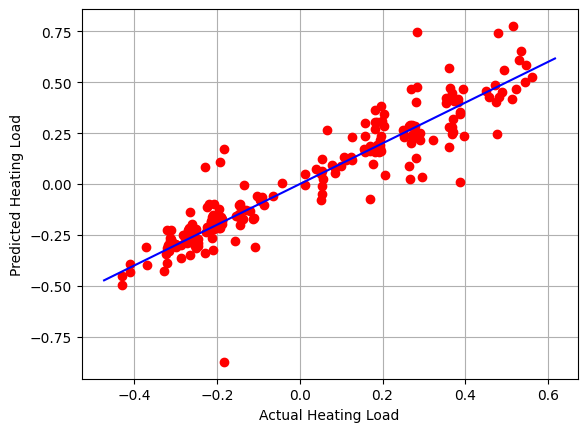

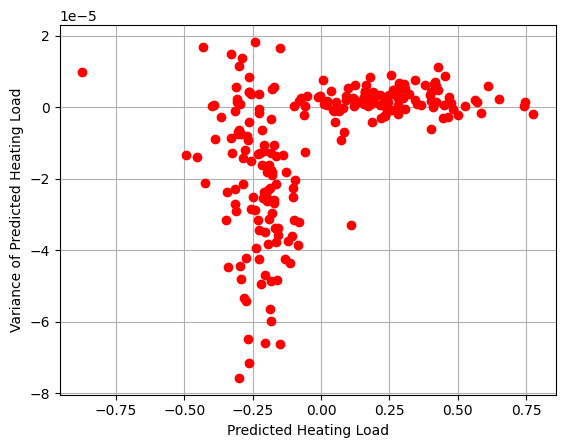

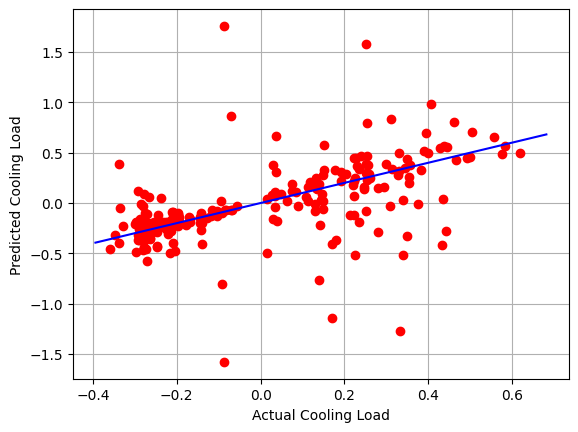

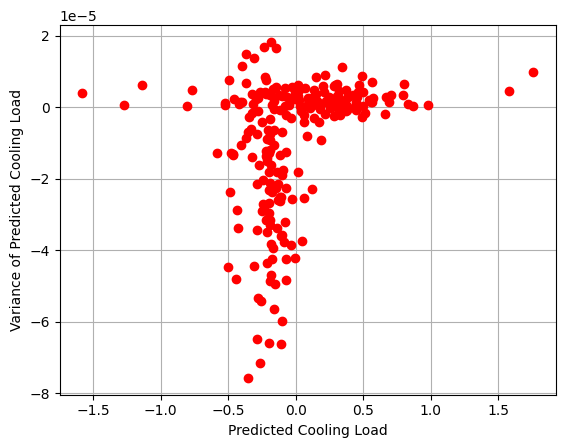

In [27]:
sigma = [1, 1]
bandwidth = [1, 1]

kernels = [lambda x, y: se_kernel(s, b, x, y)
           for s, b in zip(sigma, bandwidth)]

gpr = GaussianProcessRegression(kernels=kernels)
gpr.fit(X_train=X_train.to_numpy(),
        Y_train=Y_train.to_numpy())

Y_pred, var_Y_pred = gpr.predict(X_test=X_test.to_numpy())


print(Y_pred.shape, var_Y_pred.shape)

print('Mean squared error for Y1:')
print(mean_squared_error(Y_test['Y1'].to_numpy(), Y_pred[:, 0]))
print('Mean squared error for Y2:')
print(mean_squared_error(Y_test['Y2'].to_numpy(), Y_pred[:, 1]))


# have grid in the plots
plt.plot(Y_test['Y1'].to_numpy(), Y_pred[:, 0], 'ro')
line = np.linspace(Y_test['Y1'].min()*1.1, Y_test['Y1'].max()*1.1, 1000)
plt.plot(line, line, 'b-')
plt.xlabel('Actual Heating Load')
plt.ylabel('Predicted Heating Load')
plt.grid()
plt.show()

plt.plot(Y_pred[:, 0], var_Y_pred[:, 0], 'ro')
plt.xlabel('Predicted Heating Load')
plt.ylabel('Variance of Predicted Heating Load')
plt.grid()
plt.show()

plt.plot(Y_test['Y2'].to_numpy(), Y_pred[:, 1], 'ro')
line = np.linspace(Y_test['Y2'].min()*1.1, Y_test['Y2'].max()*1.1, 1000)
plt.plot(line, line, 'b-')
plt.xlabel('Actual Cooling Load')
plt.ylabel('Predicted Cooling Load')
plt.grid()
plt.show()

plt.plot(Y_pred[:, 1], var_Y_pred[:, 1], 'ro')
plt.xlabel('Predicted Cooling Load')
plt.ylabel('Variance of Predicted Cooling Load')
plt.grid()
plt.show()

#### Kernel Hyperparameter Tuning

In [11]:
def cross_validation(
    kernels: List[Callable],
    X: np.ndarray,
    Y: np.ndarray,
    k: int,
) -> float:
    """ Here we perform k-fold cross validation.

    Args:
        sigma (float)
        bandwidth (float)
        X (np.ndarray) : The training data.
        Y (np.ndarray) : The output for the training data.
        k (int) : The number of folds.

    Returns:
        float: The mean squared error.
    """
    N = X.shape[0]
    n = N // k
    mse = 0
    for i in range(k):
        X_train = np.concatenate((X[: i * n], X[(i + 1) * n:]))
        Y_train = np.concatenate((Y[: i * n], Y[(i + 1) * n:]))
        X_test = X[i * n: (i + 1) * n]
        Y_test = Y[i * n: (i + 1) * n]
        gpr = GaussianProcessRegression(kernels=kernels)
        gpr.fit(X_train=X_train, Y_train=Y_train)
        Y_pred, _ = gpr.predict(X_test=X_test)
        mse += mean_squared_error(Y_test, Y_pred)
    # END for
    return mse / k
# END def cross_validation

In [12]:
def grid_search(
    X: np.ndarray,
    Y: np.ndarray,
    k: int,
) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    """ Here we perform grid search to find the best hyperparameters.

    Args:
        X (np.ndarray) : The training data.
        Y (np.ndarray) : The output for the training data.
        k (int) : The number of folds.

    Returns:
        tuple: The best hyperparameters.
    """
    best_sigma: Tuple[float, float] = (np.nan, np.nan)
    best_bandwidth: Tuple[float, float] = (np.nan, np.nan)
    best_mse = np.inf

    for sigma1 in np.arange(0.1, 2.1, 0.1):
        for sigma2 in np.arange(0.1, 2.1, 0.1):
            for bandwidth1 in np.arange(0.1, 2.1, 0.1):
                for bandwidth2 in np.arange(0.1, 2.1, 0.1):
                    kernels = [lambda x, y: se_kernel(sigma1, bandwidth1, x, y),
                               lambda x, y: se_kernel(sigma2, bandwidth2, x, y)]
                    mse = cross_validation(kernels, X, Y, k)
                    
                    if mse < best_mse:
                        best_mse = mse
                        best_sigma = sigma1, sigma2
                        best_bandwidth = bandwidth1, bandwidth2
                    # END if

                # END for
            # END for
        # END for
    # END for

    return best_sigma, best_bandwidth

# END def grid_search

In [13]:
best_sigma, best_bandwidth = grid_search(X_train.to_numpy(),
                                         Y_train.to_numpy(), 5)

KeyboardInterrupt: 

In [ ]:
print(best_sigma, best_bandwidth)

In [ ]:
kernels = [lambda x, y: se_kernel(s, b, x, y)
           for s, b in zip(best_sigma, best_bandwidth)]

gpr = GaussianProcessRegression(kernels=kernels)
gpr.fit(X_train=X_train.to_numpy(),
        Y_train=Y_train.to_numpy())

Y_pred, var_Y_pred = gpr.predict(X_test=X_test.to_numpy())


print(Y_pred.shape, var_Y_pred.shape)

print('Mean squared error for Y1:')
print(mean_squared_error(Y_test['Y1'].to_numpy(), Y_pred[:, 0]))
print('Mean squared error for Y2:')
print(mean_squared_error(Y_test['Y2'].to_numpy(), Y_pred[:, 1]))


# have grid in the plots
plt.plot(Y_test['Y1'].to_numpy(), Y_pred[:, 0], 'ro')
line = np.linspace(Y_test['Y1'].min()*1.1, Y_test['Y1'].max()*1.1, 1000)
plt.plot(line, line, 'b-')
plt.xlabel('Actual Heating Load')
plt.ylabel('Predicted Heating Load')
plt.grid()
plt.show()

plt.plot(Y_pred[:, 0], var_Y_pred[:, 0], 'ro')
plt.xlabel('Predicted Heating Load')
plt.ylabel('Variance of Predicted Heating Load')
plt.grid()
plt.show()

plt.plot(Y_test['Y2'].to_numpy(), Y_pred[:, 1], 'ro')
line = np.linspace(Y_test['Y2'].min()*1.1, Y_test['Y2'].max()*1.1, 1000)
plt.plot(line, line, 'b-')
plt.xlabel('Actual Cooling Load')
plt.ylabel('Predicted Cooling Load')
plt.grid()
plt.show()

plt.plot(Y_pred[:, 1], var_Y_pred[:, 1], 'ro')
plt.xlabel('Predicted Cooling Load')
plt.ylabel('Variance of Predicted Cooling Load')
plt.grid()
plt.show()